<a href="https://colab.research.google.com/github/laufragor/face-detection-professionai/blob/main/face_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PROGETTO FACE DETECTION - ANDREA RICCIARDELLI**

# Parte 1: ***Face classifier***

Per essere in grado di rilevare più facce di dimensioni diverse in un'immagine, bisogna partire dal problema base: costruire un modello in grado di distinguere se un'immagine sia una faccia o no.  

Il tipo di modello scelto è un classificatore SVM lineare, per semplicità e perché le specifiche del progetto richiedono che il modello usi poche risorse di calcolo.  

I dataset di facce e non facce sono rispettivamente presi da [LFW-a](https://talhassner.github.io/home/projects/lfwa/index.html) e [Intel Image Classification](https://www.kaggle.com/datasets/puneet6060/intel-image-classification). Vista la grande dimensione dei dataset originali, da essi vengono estratte casualmente 3000 facce e 3000 non facce, che il modello poi userà. Le facce sono ritagliate alla dimensione 150x150, che è anche la dimensione delle non facce.

Le feature estratte dall'immagine, che vengono poi usate per addestrare il modello, sono gli *Histograms of Oriented Gradients (HOG)* - ben descritti nel [paper](https://lear.inrialpes.fr/people/triggs/pubs/Dalal-cvpr05.pdf) di Dalal e Triggs. Per strutturare il progetto mi è tornata utile [questa](https://soniaphene.github.io/facedetector/) relazione su un progetto di face detection.

Tutta la parte di machine learning viene svolta in scala di grigi per efficienza computazionale e per semplicità.

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

import cv2

# HOG (preprocessing images)
from skimage.feature import hog

# sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report

# utils
import imutils
import shutil
import time
import random
import joblib
from skimage import exposure
from google.colab.patches import cv2_imshow
from urllib.request import urlretrieve

np.set_printoptions(suppress=True)

In [ ]:
!git clone https://github.com/laufragor/face-detection-professionai

Cloning into 'face-detection-professionai'...
remote: Enumerating objects: 9770, done.
remote: Total 9770 (delta 0), reused 0 (delta 0), pack-reused 9770
Receiving objects: 100% (9770/9770), 102.68 MiB | 34.44 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [ ]:
FACES_DIR = "./face-detection-professionai/faces"
NONFACES_DIR = "./face-detection-professionai/nonfaces"

### Funzioni

In [ ]:
def images_in_dir(dirname):

    image_paths = [os.path.join(dirname, file)
                   for file in os.listdir(dirname)
                   if file.endswith((".jpg", ".jpeg", ".png"))]

    return [cv2.imread(file, cv2.IMREAD_GRAYSCALE)
            for file in image_paths]


def preprocess_image(image_gray):

    image_gray = image_gray.astype(np.float32) / 255.0
    hog_image = hog(image_gray)
    return hog_image

### Carico i dataset di facce e non-facce

In [ ]:
faces = images_in_dir(FACES_DIR)
nonfaces = images_in_dir(NONFACES_DIR)

print(len(faces), len(nonfaces), faces[0].shape, nonfaces[0].shape)    # 3000 facce e 2987 non-facce; ciascuna immagine 150x150

3000 2987 (150, 150) (150, 150)


### Mostro immagini di esempio e relativo HOG

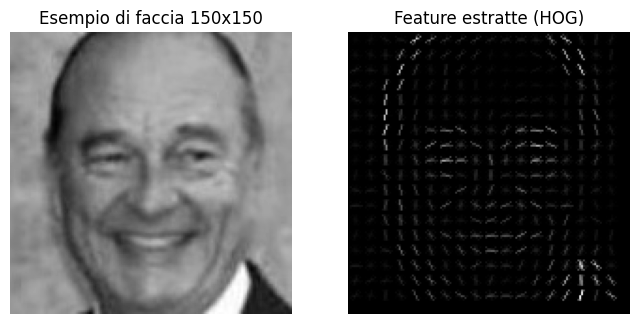

In [ ]:
img = faces[0]
_, hog_img = hog(img, visualize=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax1.axis('off')
ax2.axis('off')
ax1.imshow(img, cmap=plt.cm.gray)
ax2.imshow(hog_img, cmap=plt.cm.gray)
ax1.set_title('Esempio di faccia 150x150')
ax2.set_title('Feature estratte (HOG)')
plt.show()


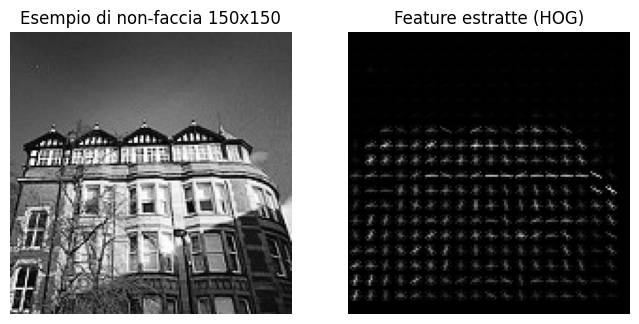

In [ ]:
img = nonfaces[2]
_, hog_img = hog(img, visualize=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax1.axis('off')
ax2.axis('off')
ax1.imshow(img, cmap=plt.cm.gray)
ax2.imshow(hog_img, cmap=plt.cm.gray)
ax1.set_title('Esempio di non-faccia 150x150')
ax2.set_title('Feature estratte (HOG)')
plt.show()

### Creo X e y

In [ ]:
X = np.concatenate((np.array(faces),    np.array(nonfaces)))
y = np.concatenate((np.ones(len(faces)), np.zeros(len(nonfaces))))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [ ]:
%%time
X_train = np.array([preprocess_image(x) for x in X_train])
X_test  = np.array([preprocess_image(x) for x in X_test])

CPU times: user 1min 15s, sys: 1.06 s, total: 1min 16s
Wall time: 1min 32s


## Modello

In [ ]:
%%time
clf = SVC(kernel="linear", probability=True)
clf.fit(X_train, y_train)

print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       598
         1.0       1.00      1.00      1.00       600

    accuracy                           1.00      1198
   macro avg       1.00      1.00      1.00      1198
weighted avg       1.00      1.00      1.00      1198

CPU times: user 2min 52s, sys: 37.3 s, total: 3min 30s
Wall time: 2min 8s


Ora che ho verificato le metriche con l'hold-out, posso fittare sull'intero dataset.

In [ ]:
X = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))

clf = SVC(kernel="linear", probability=True)
clf.fit(X, y)

SVC(kernel='linear', probability=True)

# Parte 2: ***Face detection***
Una volta addestrato un _face classifier_, per rilevare più facce nella stessa immagine si procede con la tecnica della ***SLIDING WINDOW***: si fa scorrere una piccola finestra lungo l'immagine (in altezza e in larghezza), e si classifica ogni singola istanza per capire se quella parte dell'immagine (quella "finestra") venga classificata come faccia o no. Questo procedimento si fa con l'immagine in più scale di grandezza.

Il codice della sliding window è ispirato (e semplificato) a quello presente in [questo](https://pyimagesearch.com/2015/03/23/sliding-windows-for-object-detection-with-python-and-opencv/) ottimo blog post.  



Successivamente, di solito la stessa faccia viene rilevata da più finestre (ad es. due finestre orizzontalmente adiacenti per gran parte sovrapposte). Per risolvere questo problema si applica l'algoritmo ***NON-MAXIMUM SUPPRESSION*** (NMS), che ho adattato da [questa](https://learnopencv.com/non-maximum-suppression-theory-and-implementation-in-pytorch/) versione per PyTorch.

Una volta applicata la NMS, si ottiene il risultato finale: una lista di *bounding box* con le coordinate delle facce individuate, e il relativo grado di confidenza.

In [ ]:
SLIDINGWINDOW_W, SLIDINGWINDOW_H = 150, 150
SLIDINGWINDOW_STEP_SIZE = 16
SLIDINGWINDOW_SCALE_FACTOR = 0.8
SLIDINGWINDOW_THRESH_IOU = 0.20
THRESHOLD_FACE_CONFIDENCE = 0.98
DIR_TEST_IMGS = "./face-detection-professionai/test_imgs"

### Funzioni per la face detection
La funzione `detect_faces` prende un'immagine in ingresso e ritorna una lista con le coordinate dei bounding box dove sono presenti dei volti.

In [ ]:
def preprocess_image(image_gray):

    image_gray = image_gray.astype(np.float32) / 255.0
    hog_image = hog(image_gray)
    return hog_image


def get_scaled_imgs_list(img, scale, min_img_size=(SLIDINGWINDOW_H, SLIDINGWINDOW_W)):

    scaled_imgs = []
    curr_scale = 1

    while img.shape[0] >= min_img_size[1] and img.shape[1] >= min_img_size[0]:
        scaled_imgs.append((curr_scale, img))

        new_w = int(img.shape[1] * scale)
        img = imutils.resize(img, width=new_w)
        curr_scale *= scale

    return scaled_imgs


def sliding_window(image, step_size, window_size):

    windows_topleftcoords = []

    for y in range(0, image.shape[0] - window_size[1], step_size):
        for x in range(0, image.shape[1] - window_size[0], step_size):
            windows_topleftcoords.append((x, y))

    return windows_topleftcoords


def intersection_over_union(box1, box2):

    b1x1, b1y1 = box1[0]
    b1x2, b1y2 = box1[1]
    b2x1, b2y1 = box2[0]
    b2x2, b2y2 = box2[1]

    x1_intersec = max(b1x1, b2x1)
    x2_intersec = min(b1x2, b2x2)
    y1_intersec = max(b1y1, b2y1)
    y2_intersec = min(b1y2, b2y2)

    w_intersec = max(0, x2_intersec - x1_intersec)
    h_intersec = max(0, y2_intersec - y1_intersec)

    area1 = (b1x2 - b1x1) * (b1y2 - b1y1)
    area2 = (b2x2 - b2x1) * (b2y2 - b2y1)
    area_intersec = w_intersec * h_intersec
    area_union = area1 + area2 - area_intersec

    return area_intersec / area_union


def non_maximum_suppression(bounding_boxes, thresh_IoU):

    bounding_boxes = sorted(bounding_boxes, key=lambda t: t[2])
    bounding_boxes_to_keep = []

    while len(bounding_boxes) > 0:

        highest_conf_bbox = bounding_boxes[-1]
        bounding_boxes_to_keep.append(highest_conf_bbox)
        bounding_boxes = bounding_boxes[:-1]

        if len(bounding_boxes) == 0:
            break

        idxs_bboxes_to_remove = []
        for i, bbox in enumerate(bounding_boxes):
            IoU = intersection_over_union(highest_conf_bbox, bbox)
            if IoU >= thresh_IoU:
                idxs_bboxes_to_remove.append(i)

        for i in idxs_bboxes_to_remove[::-1]:
            del bounding_boxes[i]

    return bounding_boxes_to_keep


def detect_faces(img_color):

    img = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
    scaled_imgs = get_scaled_imgs_list(img, scale=SLIDINGWINDOW_SCALE_FACTOR)
    bounding_boxes = []

    for curr_scale, scaled_img in scaled_imgs:
        windows_topleftcoords = sliding_window(scaled_img, step_size=SLIDINGWINDOW_STEP_SIZE,
                                               window_size=(SLIDINGWINDOW_W, SLIDINGWINDOW_H))

        for x, y in windows_topleftcoords:
            window = scaled_img[y: y + SLIDINGWINDOW_H, x: x + SLIDINGWINDOW_W]
            hog_image = preprocess_image(window)

            isface_confidence = clf.predict_proba([hog_image])[0, 1]
            if isface_confidence > THRESHOLD_FACE_CONFIDENCE:
                x0y0 = (int(x/curr_scale), int(y/curr_scale))
                x1y1 = (int((x + SLIDINGWINDOW_W)/curr_scale), int((y + SLIDINGWINDOW_H)/curr_scale))
                bbox = (x0y0, x1y1, isface_confidence)
                bounding_boxes.append(bbox)

    bounding_boxes_to_keep = non_maximum_suppression(bounding_boxes, thresh_IoU=SLIDINGWINDOW_THRESH_IOU)
    return bounding_boxes_to_keep


def show_results(image, bounding_boxes):

    for bbox in bounding_boxes:
        cv2.rectangle(image, bbox[0], bbox[1], (0, 255, 0), 2)
        cv2.putText(image, f"{bbox[2]:.4f}", (bbox[0][0] + 5, bbox[0][1] + 20),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 255, 0))

    cv2_imshow(image)


## Risultati

Il modello si comporta bene. Nelle immagini sottostanti è presente un numero significativo di falsi positivi, in compenso vengono individuate *tutte* le facce *frontali*.

Qui su Colab impiega circa 1' per individuare facce per ciascuna delle immagini sottostanti (con questo approccio il modello deve classificare ogni singola sliding window per più scale di grandezza dell'immagine).

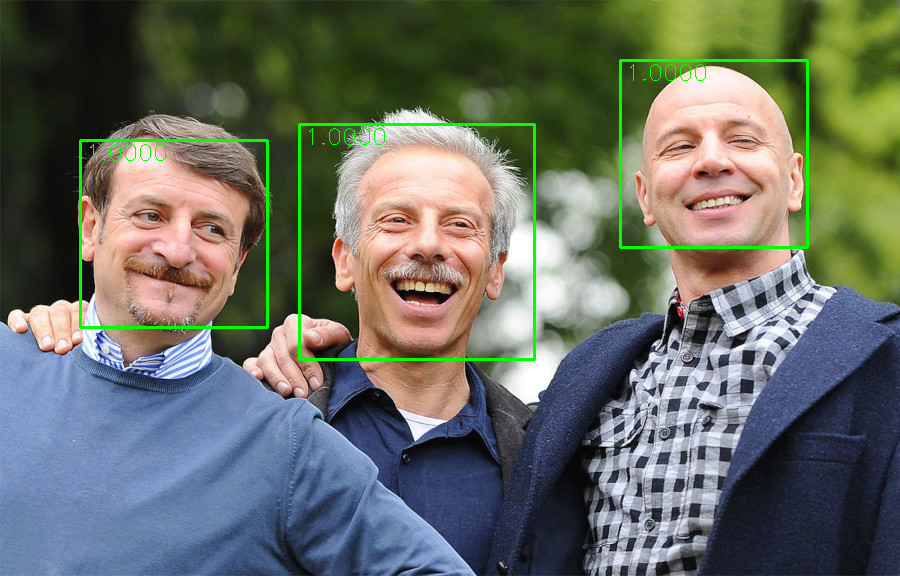

In [ ]:
test_image = 0    # from 0 to 6
img_color = cv2.imread(os.path.join(DIR_TEST_IMGS, f"{test_image}.jpg"))
show_results(img_color, detect_faces(img_color))

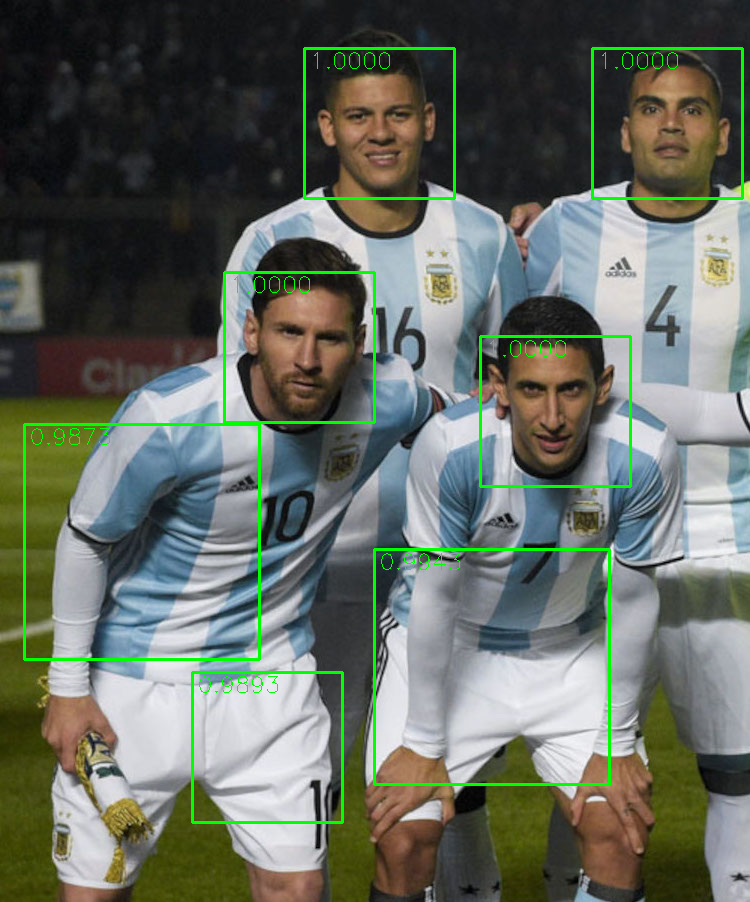

In [ ]:
test_image = 1    # from 0 to 6
img_color = cv2.imread(os.path.join(DIR_TEST_IMGS, f"{test_image}.jpg"))
show_results(img_color, detect_faces(img_color))

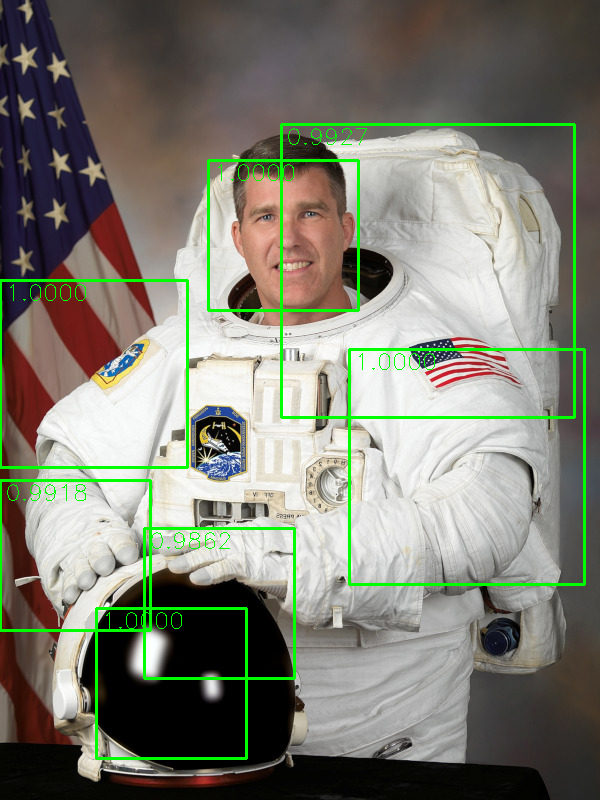

In [ ]:
test_image = 2    # from 0 to 6
img_color = cv2.imread(os.path.join(DIR_TEST_IMGS, f"{test_image}.jpg"))
show_results(img_color, detect_faces(img_color))

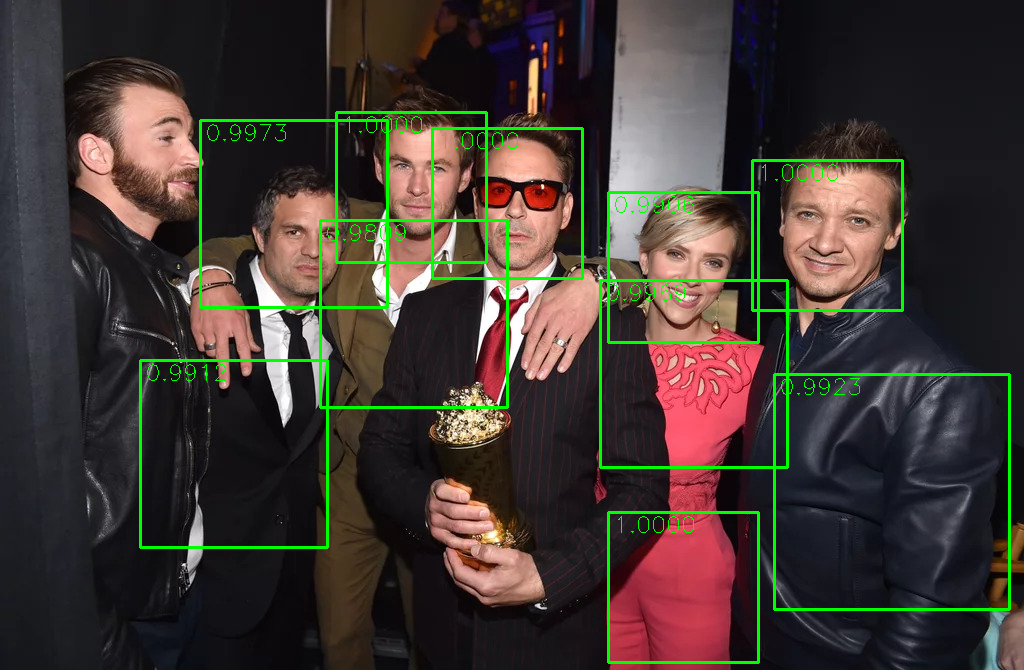

In [ ]:
test_image = 3    # from 0 to 6
img_color = cv2.imread(os.path.join(DIR_TEST_IMGS, f"{test_image}.jpg"))
show_results(img_color, detect_faces(img_color))

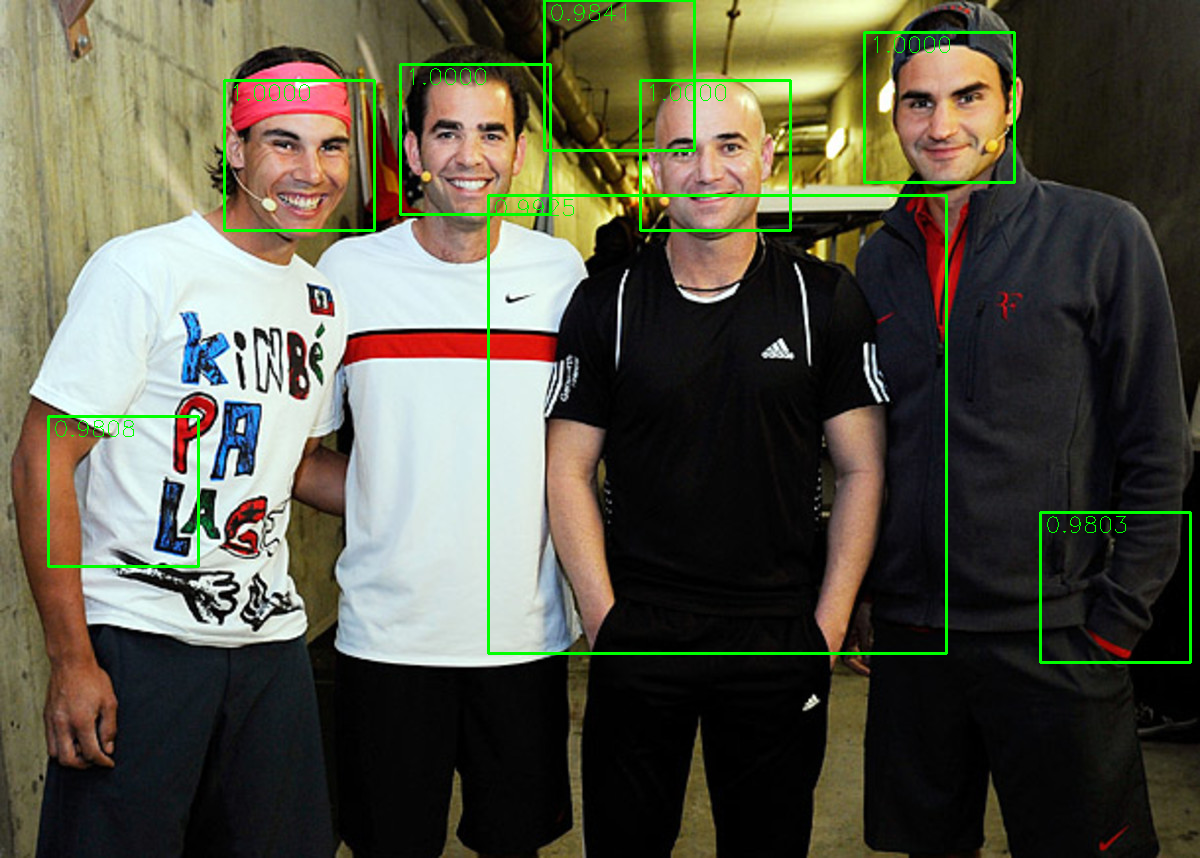

In [ ]:
test_image = 4    # from 0 to 6
img_color = cv2.imread(os.path.join(DIR_TEST_IMGS, f"{test_image}.jpg"))
show_results(img_color, detect_faces(img_color))

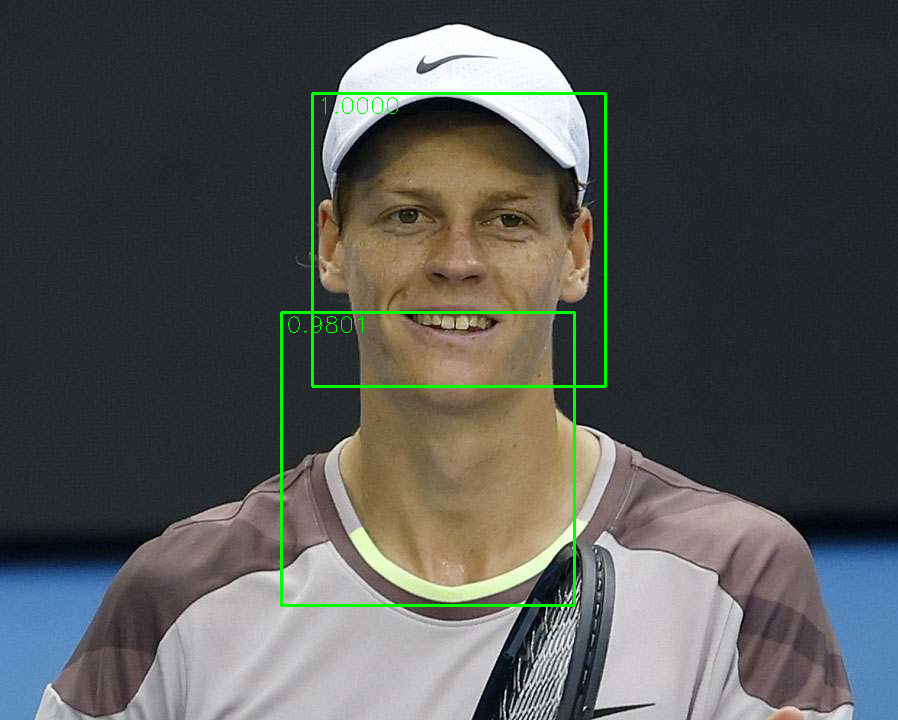

In [ ]:
test_image = 5    # from 0 to 6
img_color = cv2.imread(os.path.join(DIR_TEST_IMGS, f"{test_image}.jpg"))
show_results(img_color, detect_faces(img_color))

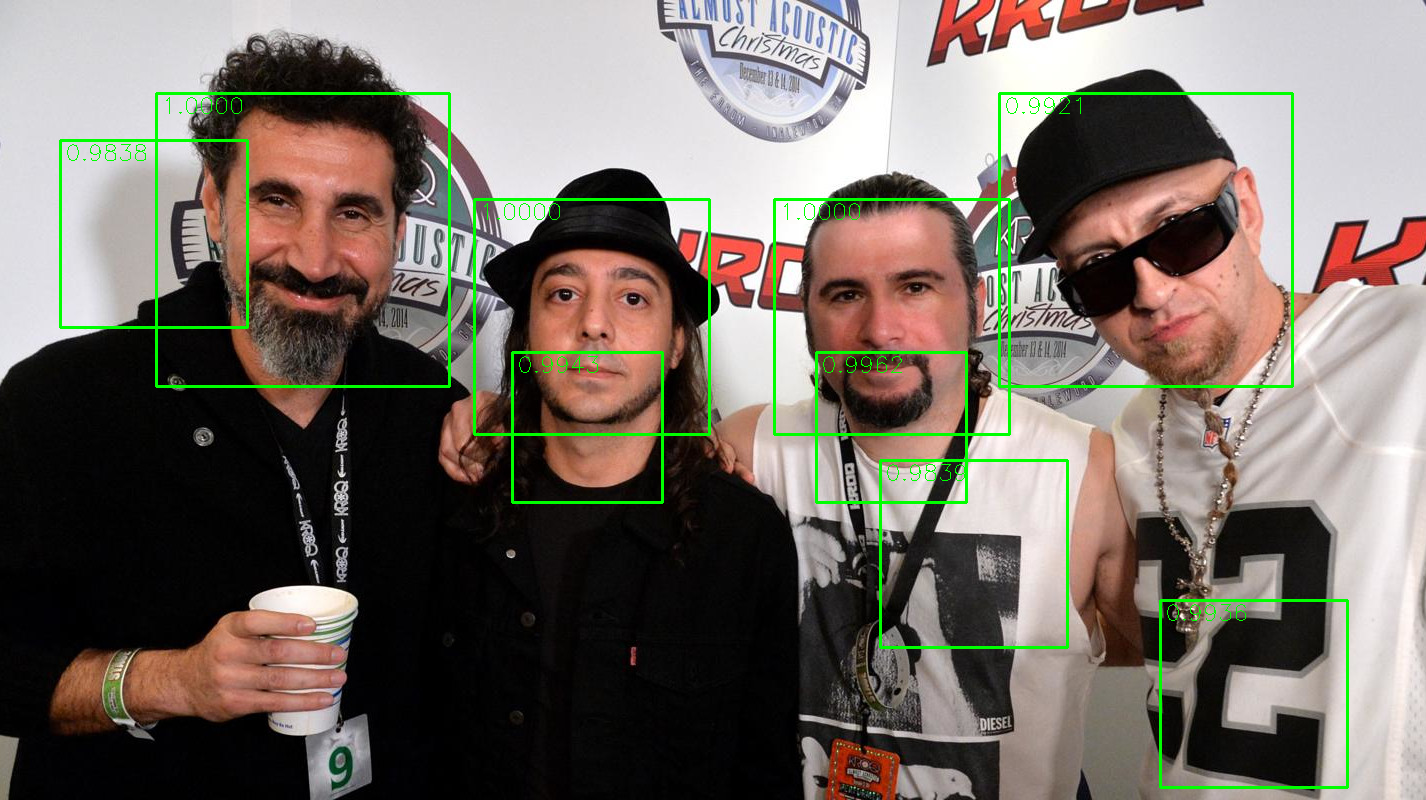

In [ ]:
test_image = 6    # from 0 to 6
img_color = cv2.imread(os.path.join(DIR_TEST_IMGS, f"{test_image}.jpg"))
show_results(img_color, detect_faces(img_color))